## Adding Necessary Libraries and Loading the Dataset

Install the following libraries


In [27]:
pip install pandas seaborn matplotlib numpy nltk

Note: you may need to restart the kernel to use updated packages.


In [19]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import re
import nltk
from wordcloud import WordCloud

/kaggle/input/uahack/reason.csv
/kaggle/input/uahack/customers.csv
/kaggle/input/uahack/test.csv
/kaggle/input/uahack/calls.csv
/kaggle/input/uahack/sentiment_statistics.csv


In [2]:
# Create identifiers for the file paths.
paths = [os.path.join(dirname, filename) for dirname, _, filenames in os.walk("/kaggle/input/") for filename in filenames]
reason_csv, customers_csv, test_csv, calls_csv, sentiment_csv = paths

In [3]:
# Load the datasets.
dframes = [pd.read_csv(path) for path in paths if "test.csv" not in path]
reason_df, customers_df, calls_df, sentiment_df = dframes

In [79]:
# Check basic info and head of each dataset to know more about data
print(calls_df.info())
print(calls_df.head(2))
print()
print(sentiment_df.info())
print(sentiment_df.head())
print()
print(reason_df.info())
print(reason_df.head())
print()
print(customers_df.info())
print(customers_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   call_id                  71810 non-null  int64 
 1   customer_id              71810 non-null  int64 
 2   agent_id                 71810 non-null  int64 
 3   call_start_datetime      71810 non-null  object
 4   agent_assigned_datetime  71810 non-null  object
 5   call_end_datetime        71810 non-null  object
 6   call_transcript          71810 non-null  object
dtypes: int64(3), object(4)
memory usage: 3.8+ MB
None
      call_id  customer_id  agent_id call_start_datetime  \
0  4667960400   2033123310    963118     7/31/2024 23:56   
1  1122072124   8186702651    519057       8/1/2024 0:03   

  agent_assigned_datetime call_end_datetime  \
0           8/1/2024 0:03     8/1/2024 0:34   
1           8/1/2024 0:06     8/1/2024 0:18   

                                     

## Preprocessing the Data

In [13]:
# Convert date columns to datetime objects
calls_df["call_start_datetime"] = pd.to_datetime(calls_df["call_start_datetime"])
calls_df["agent_assigned_datetime"] = pd.to_datetime(calls_df["agent_assigned_datetime"])
calls_df["call_end_datetime"] = pd.to_datetime(calls_df["call_end_datetime"])

In [14]:
# Calculate AHT and AST in minutes
calls_df["handling_time"] = (calls_df['call_end_datetime'] - calls_df['agent_assigned_datetime']).dt.components.minutes + \
                        (calls_df['call_end_datetime'] - calls_df['agent_assigned_datetime']).dt.components.hours * 60

calls_df["call_wait_time"] = (calls_df['agent_assigned_datetime'] - calls_df['call_start_datetime']).dt.components.minutes + \
                           (calls_df['agent_assigned_datetime'] - calls_df['call_start_datetime']).dt.components.hours * 60

In [15]:
# Merging dataframes to create single dataframe.
merged_df = calls_df.merge(customers_df, on="customer_id", how="left")\
.merge(sentiment_df, on="call_id", how="left")\
.merge(reason_df, on="call_id", how="left")

merged_df.head()

,call_id,customer_id,agent_id_x,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,handling_time,call_wait_time,customer_name,elite_level_code,agent_id_y,agent_tone,customer_tone,average_sentiment,silence_percent_average,primary_call_reason
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,31,7,Matthew Foster,4.0,963118,neutral,angry,-0.04,0.39,Voluntary Cancel
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,12,3,Tammy Walters,NaN,519057,calm,neutral,0.02,0.35,Booking
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,19,8,Jeffery Dixon,NaN,158319,neutral,polite,-0.13,0.32,IRROPS
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,7,5,David Wilkins,2.0,488324,neutral,frustrated,-0.20,0.20,Upgrade
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,9,10,Elizabeth Daniels,0.0,721730,neutral,polite,-0.05,0.35,Seating


In [83]:
# Calculating overall AHT and AST
overall_aht = merged_df["handling_time"].mean()
overall_ast = merged_df["call_wait_time"].mean()

In [84]:
f"Overall AHT: {overall_aht}"

'Overall AHT: 11.61747667455786'

In [85]:
f"Overall AST: {overall_ast}"

'Overall AST: 7.284458988998747'

In [86]:
# AHT by agent id
agent_performance = merged_df.groupby("agent_id_x")["handling_time"].mean().reset_index()

agent_performance

,agent_id_x,handling_time
0,102574,60.000000
1,103651,12.456376
2,106000,11.486726
3,107876,16.500000
4,112609,14.181818
...,...,...
378,981776,11.718447
379,981779,11.396476
380,982131,12.037037
381,992521,15.826087


In [87]:
# AHT by customer importance or elite level
elite_aht = merged_df.groupby("elite_level_code")["handling_time"].mean().reset_index()

elite_aht

,elite_level_code,handling_time
0,0.0,11.599986
1,1.0,11.472860
2,2.0,12.107499
3,3.0,12.125174
4,4.0,13.137412
5,5.0,14.949177


In [88]:
# Correlation between sentiment and AHT
sentiment_aht_correlation = merged_df[["average_sentiment", "handling_time"]].corr()

sentiment_aht_correlation

,average_sentiment,handling_time
average_sentiment,1.000000,-0.076065
handling_time,-0.076065,1.000000


In [89]:
# Correlation between sentiment and AHT
sentiment_aht_correlation = merged_df[["average_sentiment", "handling_time"]].corr()

sentiment_aht_correlation

,average_sentiment,handling_time
average_sentiment,1.000000,-0.076065
handling_time,-0.076065,1.000000


In [90]:
# Analyzing the impact of silence during calls on AHT
silence_aht_correlation = merged_df.groupby("silence_percent_average")["handling_time"].mean().reset_index()

silence_aht_correlation

,silence_percent_average,handling_time
0,0.00,1.677419
1,0.01,5.672862
2,0.02,4.237430
3,0.03,4.397761
4,0.04,4.583604
...,...,...
94,0.94,5.500000
95,0.95,20.500000
96,0.96,16.333333
97,0.97,9.666667


In [91]:
# Normalize the primary_call_reason column
merged_df["primary_call_reason"] = merged_df["primary_call_reason"].str.strip()  # Remove leading/trailing whitespaces.
merged_df["primary_call_reason"] = merged_df["primary_call_reason"].str.replace(r"[^\w\s]", " ", regex=True)  # Remove punctuation.
merged_df["primary_call_reason"] = merged_df["primary_call_reason"].str.replace(r"\s+", " ", regex=True)  # Remove multiple spaces.
merged_df["primary_call_reason"] = merged_df["primary_call_reason"].str.lower()  # Convert to lowercase.
merged_df["primary_call_reason"] = merged_df["primary_call_reason"].str.replace("products services", "products and services")

In [92]:
merged_df["primary_call_reason"].unique()

array(['voluntary cancel', 'booking', 'irrops', 'upgrade', 'seating',
       'mileage plus', 'checkout', nan, 'voluntary change', 'post flight',
       'check in', 'other topics', 'communications', 'schedule change',
       'products and services', 'digital support', 'disability',
       'unaccompanied minor', 'baggage', 'traveler updates', 'etc'],
      dtype=object)

In [93]:
# Analyzing AHT by call reason
reason_aht_mean = merged_df.groupby("primary_call_reason")["handling_time"].mean().reset_index()

reason_aht_mean

,primary_call_reason,handling_time
0,baggage,5.560734
1,booking,7.128934
2,check in,9.568803
3,checkout,16.947564
4,communications,13.778646
5,digital support,6.204898
6,disability,4.868486
7,etc,16.048319
8,irrops,13.085268
9,mileage plus,16.592890


In [94]:
# Analyzing relation of silence with call reason
silence_reason_correlation = merged_df.groupby("primary_call_reason")["silence_percent_average"].mean().reset_index()

silence_reason_correlation

,primary_call_reason,silence_percent_average
0,baggage,0.250508
1,booking,0.260948
2,check in,0.262736
3,checkout,0.292309
4,communications,0.303578
5,digital support,0.285298
6,disability,0.248635
7,etc,0.287563
8,irrops,0.309404
9,mileage plus,0.275038


## Analyzing the Data and Creating Plots

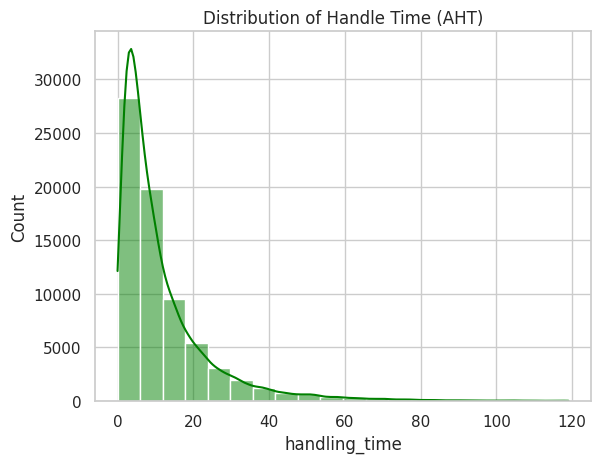

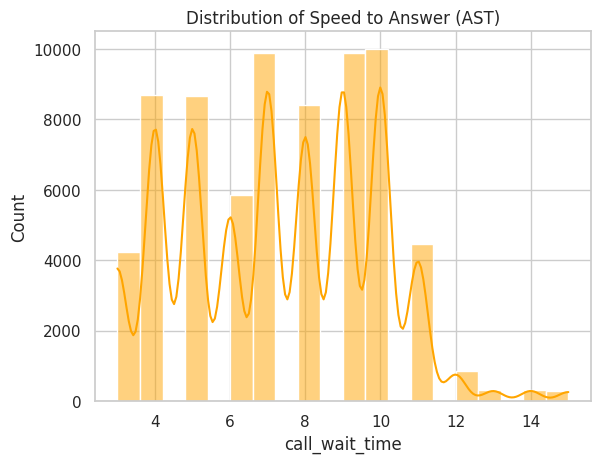

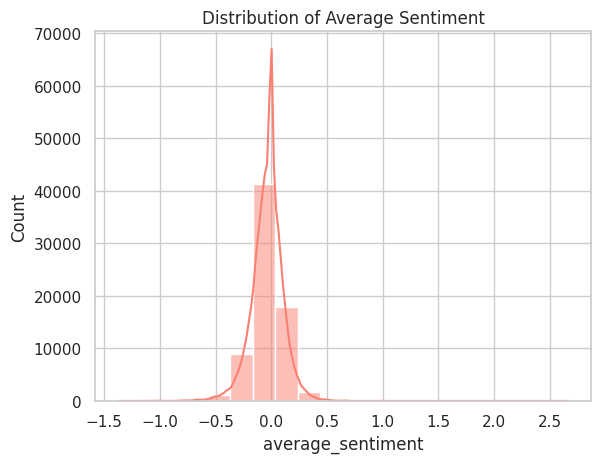

In [95]:
# Handling Time distribution
sns.histplot(merged_df['handling_time'], bins=20, kde=True, color="green")
plt.title('Distribution of Handle Time (AHT)')
plt.show()

# Call wait time distribution
sns.histplot(merged_df['call_wait_time'], bins=20, kde=True, color="orange")
plt.title('Distribution of Speed to Answer (AST)')
plt.show()

# Sentiment Distribution
sns.histplot(merged_df['average_sentiment'], bins=20, kde=True, color = "salmon")
plt.title('Distribution of Average Sentiment')
plt.show()


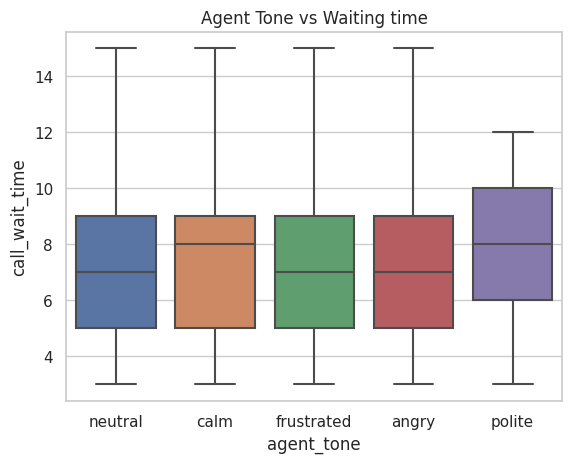

In [96]:
# Agent tone and speed to answer
sns.boxplot(x='agent_tone', y='call_wait_time', data=merged_df)
plt.title('Agent Tone vs Waiting time')
plt.show()

primary_call_reason
checkout                 16.947564
mileage plus             16.592890
etc                      16.048319
post flight              15.548268
communications           13.778646
irrops                   13.085268
products and services    12.442677
voluntary cancel         12.031114
voluntary change         10.652563
upgrade                  10.539080
check in                  9.568803
unaccompanied minor       8.653846
schedule change           8.166895
seating                   7.916575
booking                   7.128934
traveler updates          6.553895
digital support           6.204898
other topics              5.834963
baggage                   5.560734
disability                4.868486
Name: handling_time, dtype: float64


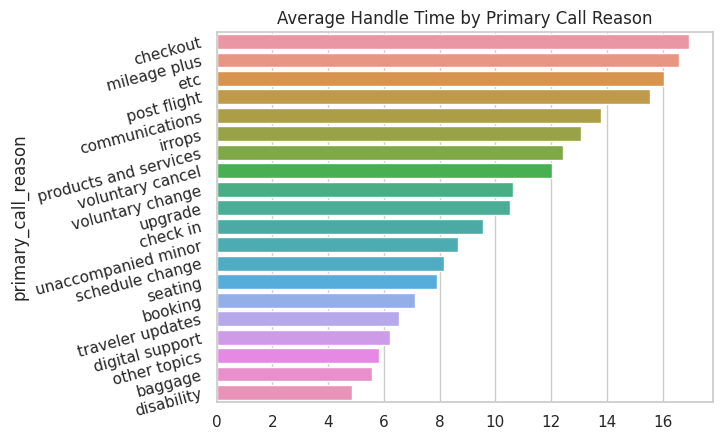

In [97]:
# Average handle time by primary call reason
reason_aht = merged_df.groupby('primary_call_reason')['handling_time'].mean().sort_values(ascending=False)
print(reason_aht)
sns.barplot(y=reason_aht.index, x=reason_aht.values)
plt.title('Average Handle Time by Primary Call Reason')
plt.yticks(rotation=15)
plt.show()


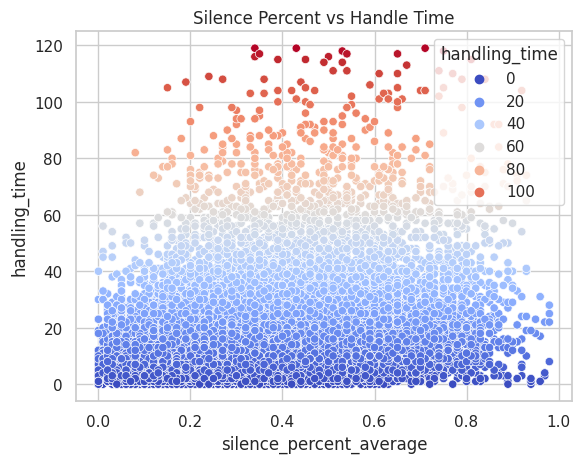

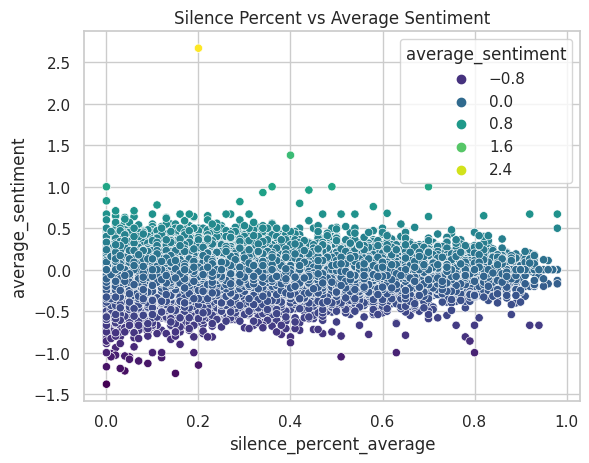

In [98]:
sns.scatterplot(x='silence_percent_average', y='handling_time', data=merged_df, hue='handling_time', palette='coolwarm')
plt.title('Silence Percent vs Handle Time')
plt.show()
sns.scatterplot(x='silence_percent_average', y='average_sentiment', data=merged_df, hue='average_sentiment', palette='viridis')
plt.title('Silence Percent vs Average Sentiment')
plt.show()



In [99]:
def top_two_frequent_counts(x):
    counts = x.value_counts()
    top_two_counts = counts.nlargest(2).index
    
    return top_two_counts.tolist()
silence_reason_correlation = merged_df.groupby("primary_call_reason")["silence_percent_average"].apply(top_two_frequent_counts).reset_index()
silence_reason_correlation

,primary_call_reason,silence_percent_average
0,baggage,"[0.0, 0.12]"
1,booking,"[0.0, 0.18]"
2,check in,"[0.04, 0.12]"
3,checkout,"[0.15, 0.18]"
4,communications,"[0.17, 0.27]"
5,digital support,"[0.0, 0.19]"
6,disability,"[0.12, 0.07]"
7,etc,"[0.28, 0.27]"
8,irrops,"[0.13, 0.19]"
9,mileage plus,"[0.24, 0.22]"


In [100]:
def top_two_frequent_counts(x):
    counts = x.value_counts()
    top_two_counts_mean = np.mean(counts.nlargest(2).index)
    
    return top_two_counts_mean


silence_reason_correlation = merged_df.groupby("primary_call_reason")["silence_percent_average"].apply(top_two_frequent_counts).reset_index()

silence_reason_correlation

,primary_call_reason,silence_percent_average
0,baggage,0.060
1,booking,0.090
2,check in,0.080
3,checkout,0.165
4,communications,0.220
5,digital support,0.095
6,disability,0.095
7,etc,0.275
8,irrops,0.160
9,mileage plus,0.230


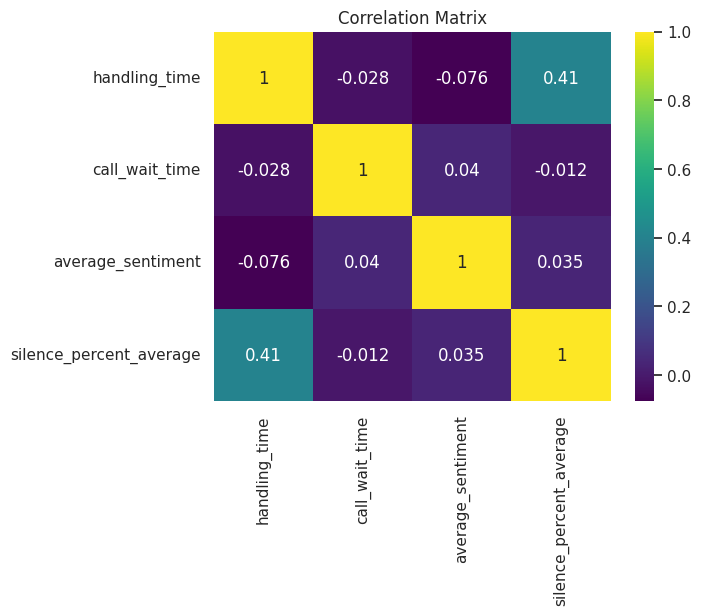

In [101]:
# Interaction of data features with one another
correlation_matrix = merged_df[['handling_time', 'call_wait_time', 'average_sentiment', 'silence_percent_average']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()


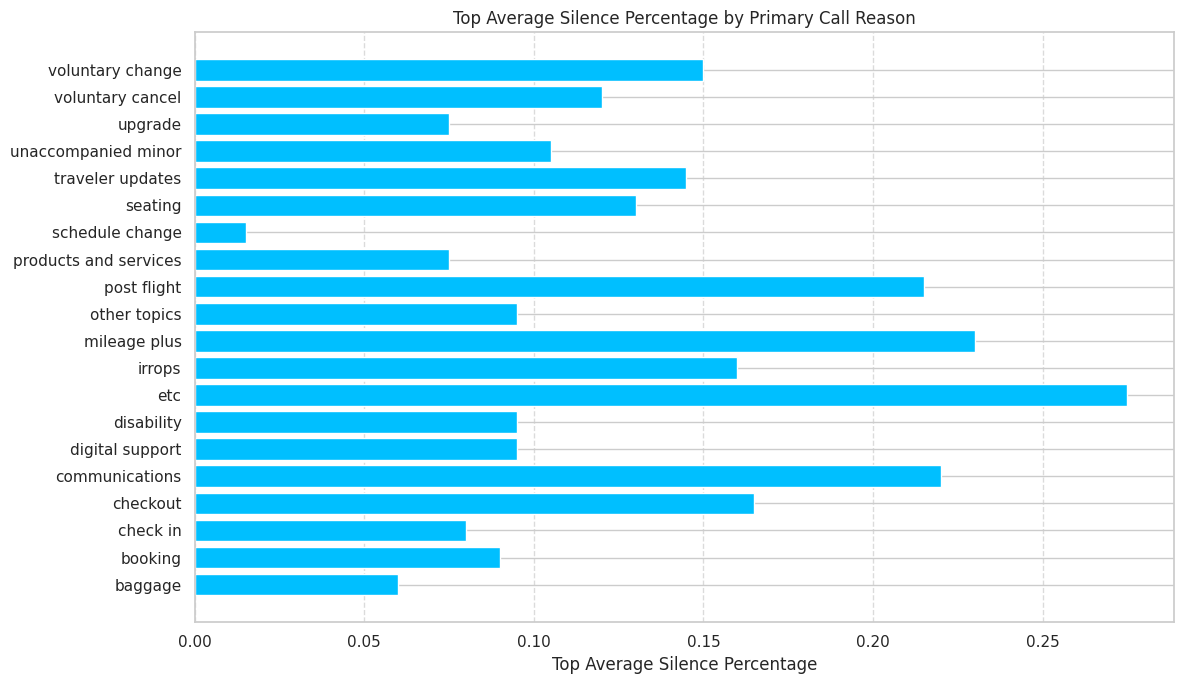

In [102]:
# Top average silence by call reason
plt.figure(figsize=(12, 7))
plt.barh(silence_reason_correlation["primary_call_reason"], silence_reason_correlation["silence_percent_average"], color="deepskyblue")
plt.xlabel("Top Average Silence Percentage")
plt.title("Top Average Silence Percentage by Primary Call Reason")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

AHT Statistics:
 count    71810.000000
mean        11.617477
std         12.905025
min          0.000000
25%          4.000000
50%          7.000000
75%         15.000000
max        119.000000
Name: handling_time, dtype: float64

AST Statistics:
 count    71810.000000
mean         7.284459
std          2.518830
min          3.000000
25%          5.000000
50%          7.000000
75%          9.000000
max         15.000000
Name: call_wait_time, dtype: float64

Average Sentiment Score: -0.03
Average Silence Percentage: 0.29

Agent Tone Distribution:
 agent_tone
neutral       42758
calm          24675
frustrated     3684
angry           389
polite           87
Name: count, dtype: int64

Primary Call Reason Distribution:
 primary_call_reason
irrops                   13311
voluntary change         10848
seating                   6365
mileage plus              5851
post flight               4330
communications            3840
products and services     3332
baggage                   2832
upgrade

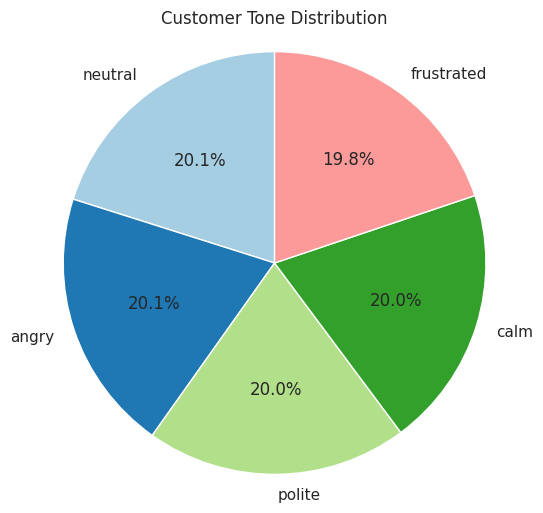

In [104]:
# Average sentiment statistics
aht_stats = merged_df['handling_time'].describe()
ast_stats = merged_df['call_wait_time'].describe()
avg_sentiment = merged_df['average_sentiment'].mean()
silence_avg = merged_df['silence_percent_average'].mean()

# Distribution of agent and customer tones
agent_tone_distribution = merged_df['agent_tone'].value_counts()
customer_tone_distribution = merged_df['customer_tone'].value_counts()

# Call reasons distribution
call_reason_distribution = merged_df['primary_call_reason'].value_counts()

# Elite vs non-elite customer impact on AHT and AST
elite_aht = merged_df[merged_df['elite_level_code'] > 0]['handling_time'].mean()
non_elite_aht = merged_df[merged_df['elite_level_code'] == 0]['handling_time'].mean()

elite_ast = merged_df[merged_df['elite_level_code'] > 0]['call_wait_time'].mean()
non_elite_ast = merged_df[merged_df['elite_level_code'] == 0]['call_wait_time'].mean()

# Peak call times
merged_df['call_hour'] = merged_df['call_start_datetime'].dt.hour
peak_hours = merged_df['call_hour'].value_counts().head(25)

# Key insights
print("AHT Statistics:\n", aht_stats)
print("\nAST Statistics:\n", ast_stats)
print(f"\nAverage Sentiment Score: {avg_sentiment:.2f}")
print(f"Average Silence Percentage: {silence_avg:.2f}")
print("\nAgent Tone Distribution:\n", agent_tone_distribution)
print("\nPrimary Call Reason Distribution:\n", call_reason_distribution)
print(f"\nAverage AHT for Elite Customers: {elite_aht:.2f} minutes")
print(f"Average AHT for Non-Elite Customers: {non_elite_aht:.2f} minutes")
print(f"Average AST for Elite Customers: {elite_ast:.2f} minutes")
print(f"Average AST for Non-Elite Customers: {non_elite_ast:.2f} minutes")
print("\nPeak Call Hours:\n", peak_hours)

# Distribution of customer tone on calls
plt.figure(figsize=(6, 6))
plt.pie(customer_tone_distribution, labels=customer_tone_distribution.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Customer Tone Distribution')
plt.axis('equal')
plt.show()


In [105]:
reason_htime_silence = reason_aht_mean.merge(silence_reason_correlation, on="primary_call_reason", how="left")

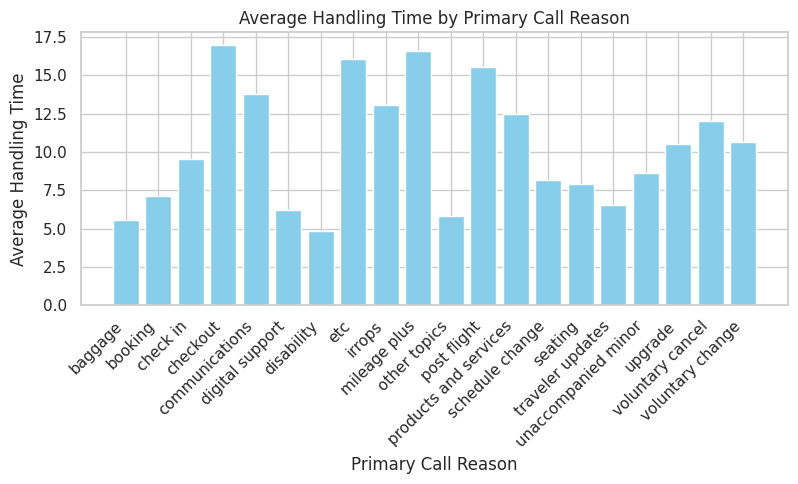

In [107]:
# Plotting average handling time again primary call reason
plt.figure(figsize=(8, 5))
plt.bar(reason_htime_silence['primary_call_reason'], reason_htime_silence['handling_time'], color='skyblue')
plt.xlabel('Primary Call Reason')
plt.ylabel('Average Handling Time')
plt.title('Average Handling Time by Primary Call Reason')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

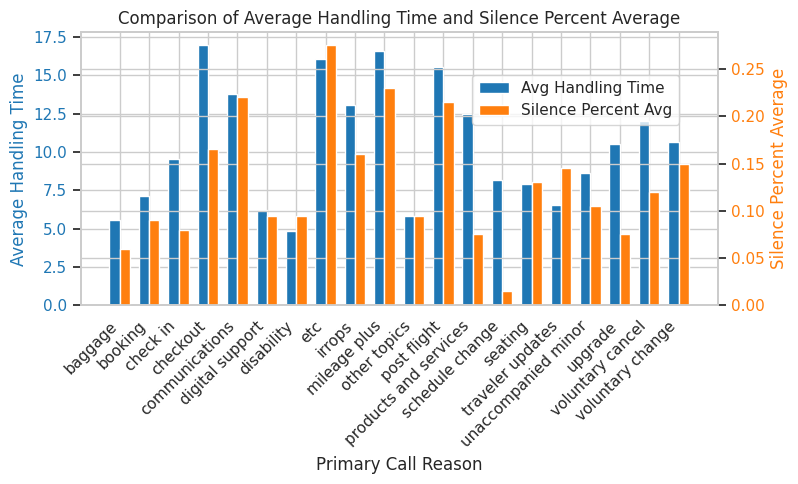

In [108]:
fig, ax1 = plt.subplots(figsize=(8, 5))
bar_width = 0.35
index = np.arange(len(reason_htime_silence['primary_call_reason']))

# Plot the first dataset on the left y-axis
color = 'tab:blue'
bars1 = ax1.bar(index, reason_htime_silence['handling_time'], bar_width, color=color, label='Avg Handling Time')
ax1.set_ylabel('Average Handling Time', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create the second y-axis
ax2 = ax1.twinx()  # Create a twin Axes sharing the x-axis
color = 'tab:orange'
bars2 = ax2.bar(index + bar_width, reason_htime_silence['silence_percent_average'], bar_width, color=color, label='Silence Percent Avg')
ax2.set_ylabel('Silence Percent Average', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Adding labels and title
ax1.set_xlabel('Primary Call Reason')
ax1.set_title('Comparison of Average Handling Time and Silence Percent Average')

# Set the x-ticks and labels
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(reason_htime_silence['primary_call_reason'])

# Show legend
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))

# Rotate x-axis labels
# Rotate x-axis labels for better readability
for label in ax1.get_xticklabels():
    label.set_rotation(45)  # Rotate each label
    label.set_ha('right')

# Show the plot
plt.tight_layout()
plt.show()

In [109]:
def top_two_frequent_counts(x):
    counts = x.value_counts()
    top_two_counts_mean = np.mean(counts.nlargest(2).index)
    
    return top_two_counts_mean


agent_performance_mode = merged_df.groupby("agent_id_x")["handling_time"].apply(top_two_frequent_counts).reset_index()

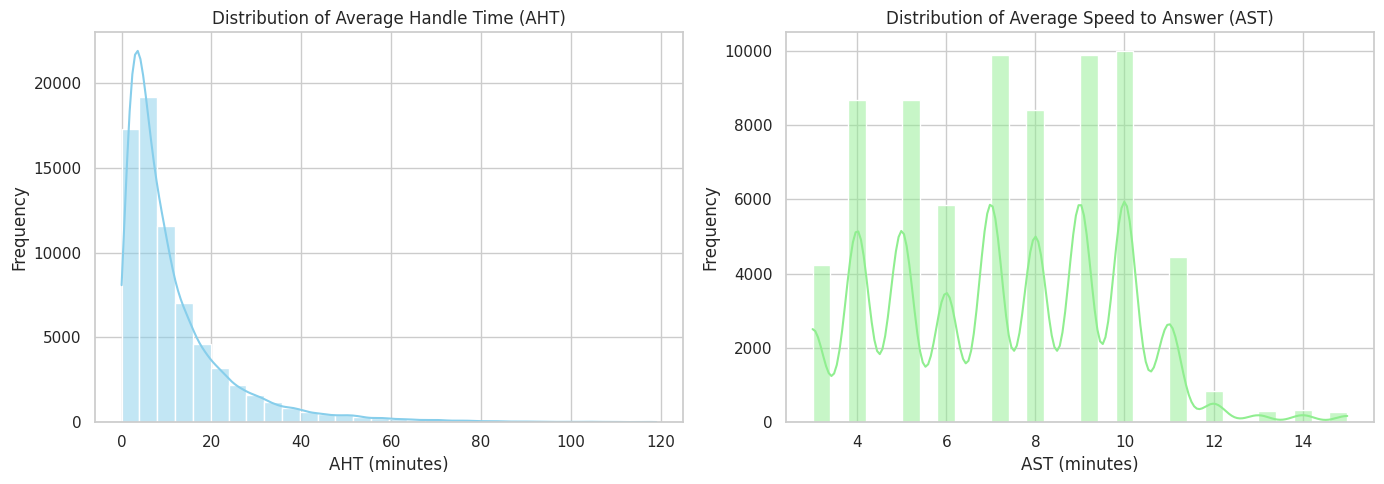

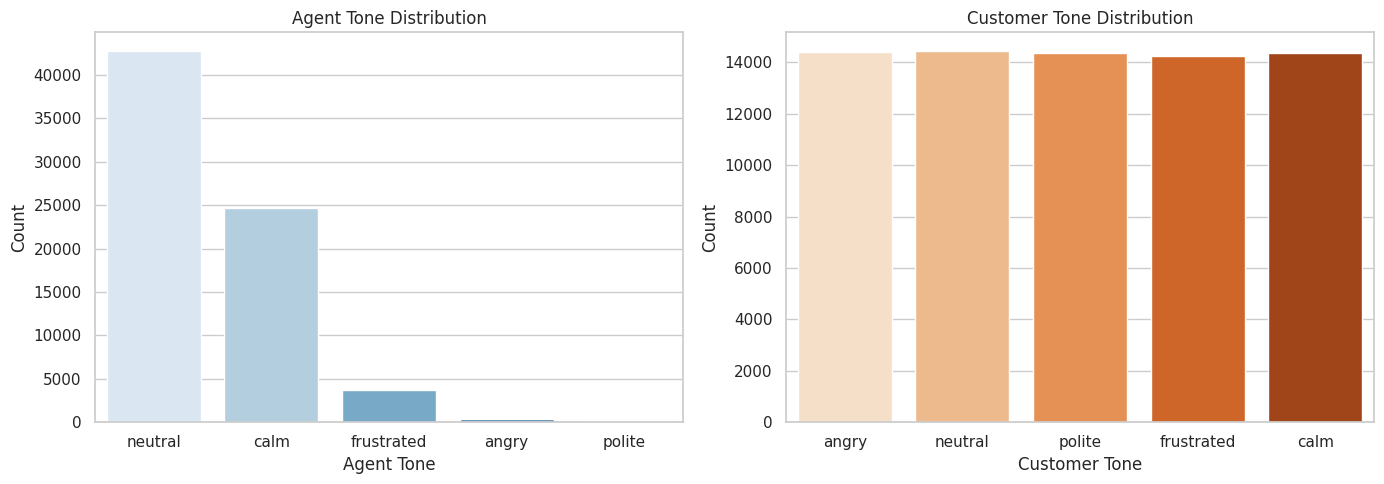

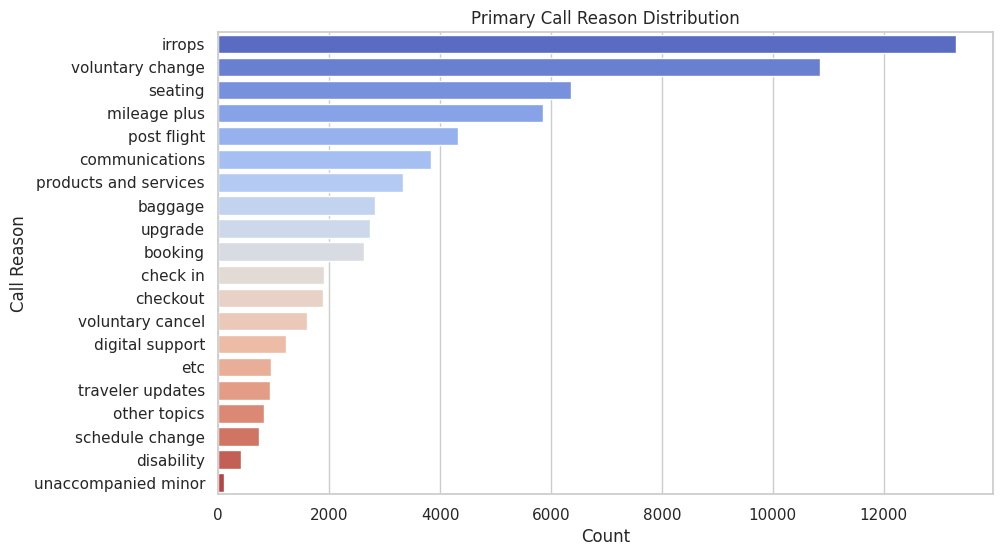

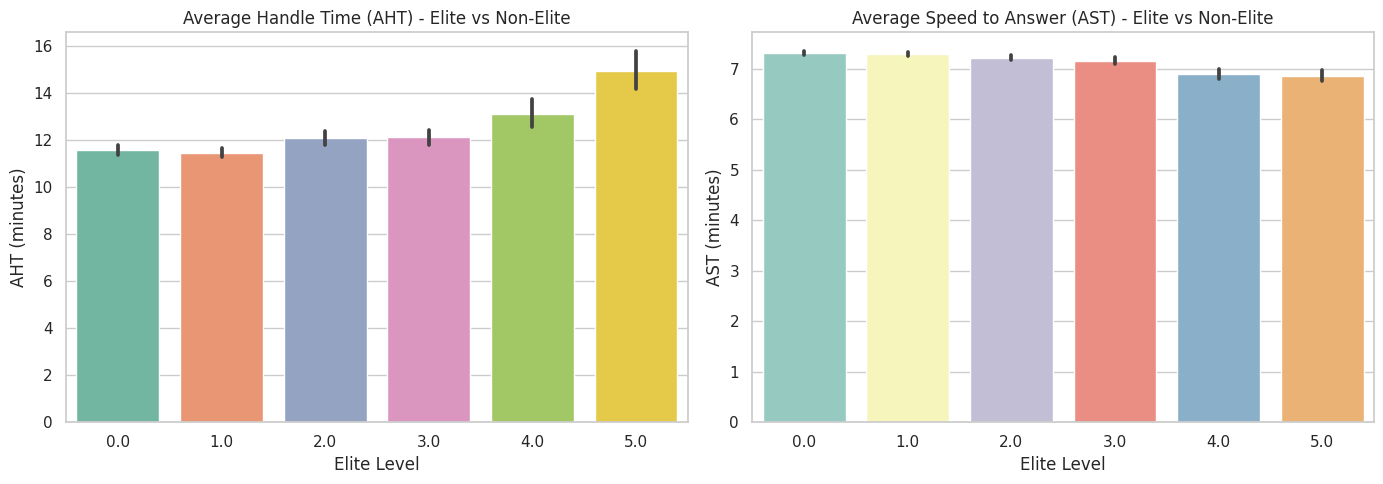

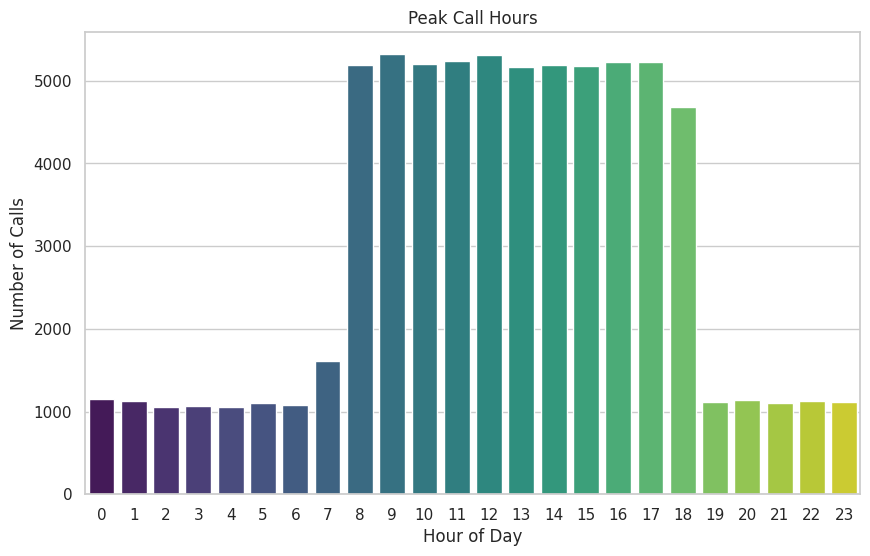

In [112]:
sns.set(style="whitegrid")
# AHT and AST Statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# AHT Distribution
sns.histplot(merged_df['handling_time'], bins=30, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Distribution of Average Handle Time (AHT)")
axes[0].set_xlabel("AHT (minutes)")
axes[0].set_ylabel("Frequency")
# AST Distribution
sns.histplot(merged_df['call_wait_time'], bins=30, kde=True, ax=axes[1], color="lightgreen")
axes[1].set_title("Distribution of Average Speed to Answer (AST)")
axes[1].set_xlabel("AST (minutes)")
axes[1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# Tone Distributions (Agent and Customer)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Agent Tone
sns.countplot(x='agent_tone', data=merged_df, palette='Blues', ax=axes[0])
axes[0].set_title("Agent Tone Distribution")
axes[0].set_xlabel("Agent Tone")
axes[0].set_ylabel("Count")

# Customer Tone
sns.countplot(x='customer_tone', data=merged_df, palette='Oranges', ax=axes[1])
axes[1].set_title("Customer Tone Distribution")
axes[1].set_xlabel("Customer Tone")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

# Call Reason Distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='primary_call_reason', data=merged_df, palette='coolwarm', order=merged_df['primary_call_reason'].value_counts().index)
plt.title("Primary Call Reason Distribution")
plt.xlabel("Count")
plt.ylabel("Call Reason")
plt.show()

# Elite vs Non Elite AHT and AST
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elite vs Non Elite AHT
sns.barplot(x='elite_level_code', y='handling_time', data=merged_df, ax=axes[0], palette='Set2')
axes[0].set_title("Average Handle Time (AHT) - Elite vs Non-Elite")
axes[0].set_xlabel("Elite Level")
axes[0].set_ylabel("AHT (minutes)")

# Elite vs Non Elite AST
sns.barplot(x='elite_level_code', y='call_wait_time', data=merged_df, ax=axes[1], palette='Set3')
axes[1].set_title("Average Speed to Answer (AST) - Elite vs Non-Elite")
axes[1].set_xlabel("Elite Level")
axes[1].set_ylabel("AST (minutes)")

plt.tight_layout()
plt.show()

# Peak Call Hours
plt.figure(figsize=(10, 6))
sns.countplot(x='call_hour', data=merged_df, palette='viridis')
plt.title("Peak Call Hours")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Calls")
plt.show()


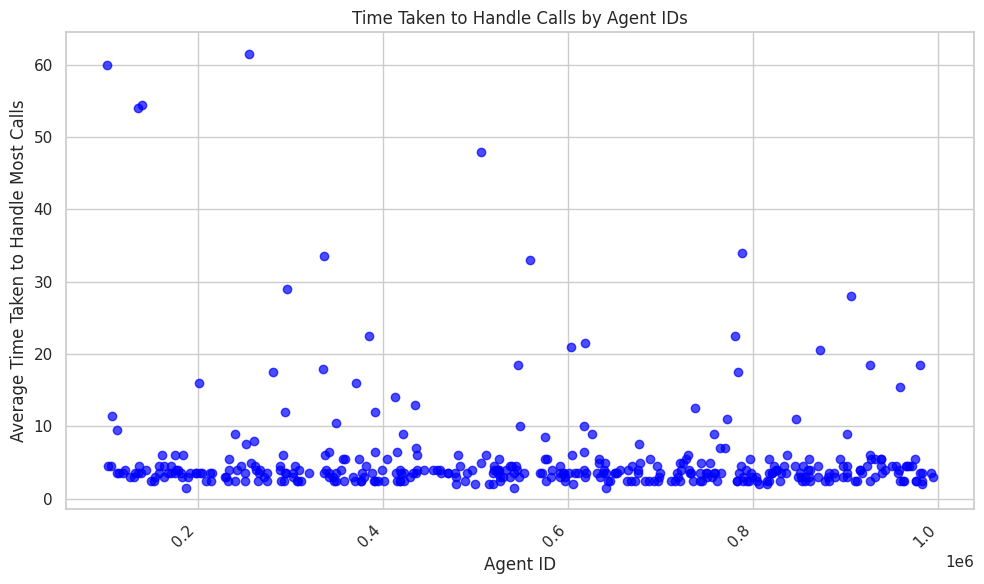

In [111]:
# Scatter plot for time taken to handle calls
plt.figure(figsize=(10, 6))
plt.scatter(agent_performance_mode['agent_id_x'], agent_performance_mode['handling_time'], color='blue', alpha=0.7)
plt.xlabel('Agent ID')
plt.ylabel('Average Time Taken to Handle Most Calls')  # Updated label
plt.title('Time Taken to Handle Calls by Agent IDs')  # Updated title
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

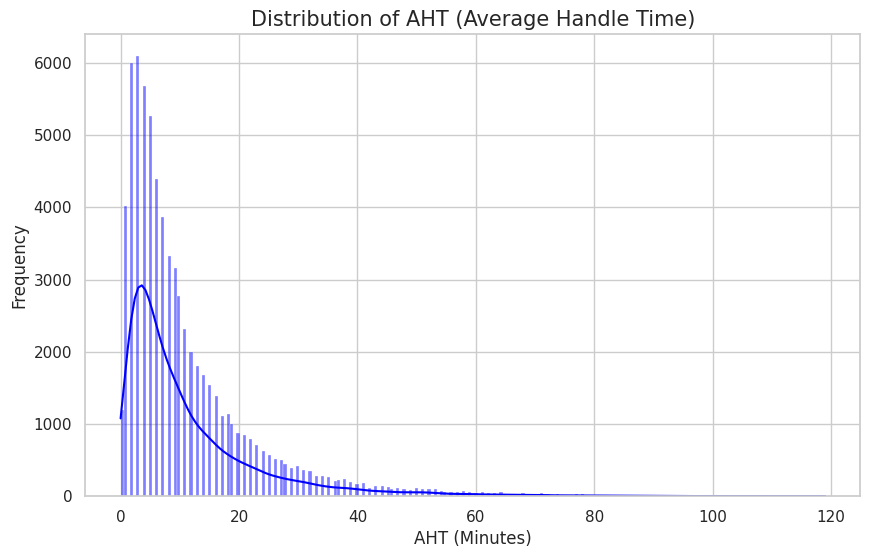

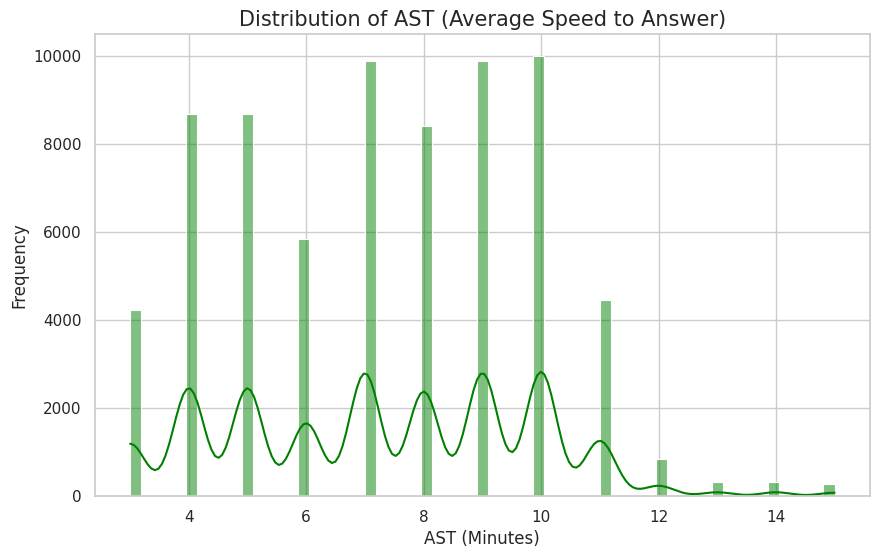

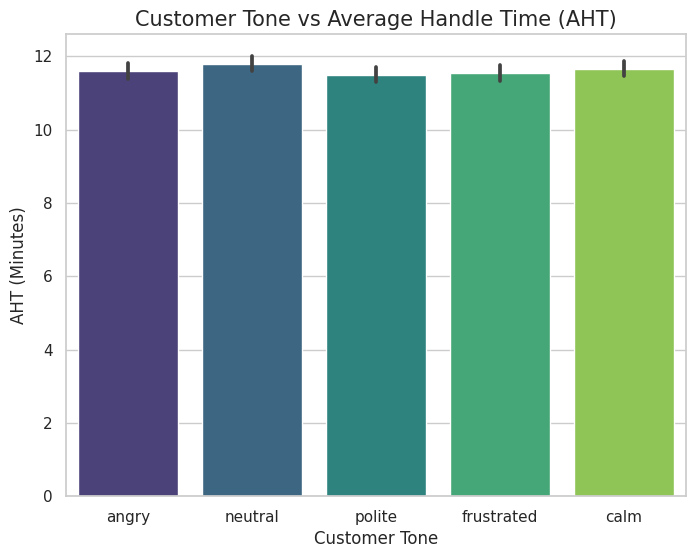

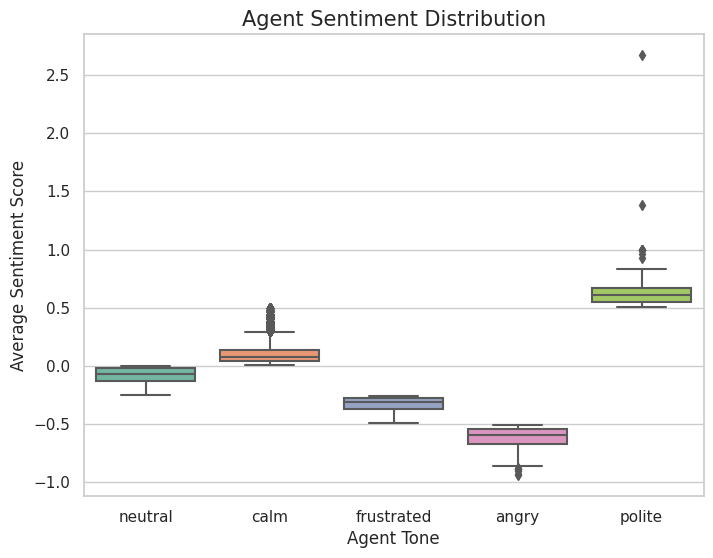

In [113]:
Distribution of AHT 
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['handling_time'], kde=True, color='blue')
plt.title('Distribution of AHT (Average Handle Time)', fontsize=15)
plt.xlabel('AHT (Minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Distribution of AST
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['call_wait_time'], kde=True, color='green')
plt.title('Distribution of AST (Average Speed to Answer)', fontsize=15)
plt.xlabel('AST (Minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Customer Tone vs AHT
plt.figure(figsize=(8, 6))
sns.barplot(x='customer_tone', y='handling_time', data=merged_df, palette='viridis')
plt.title('Customer Tone vs Average Handle Time (AHT)', fontsize=15)
plt.xlabel('Customer Tone', fontsize=12)
plt.ylabel('AHT (Minutes)', fontsize=12)
plt.show()

# Agent Sentiment Analysis
plt.figure(figsize=(8, 6))
sns.boxplot(x='agent_tone', y='average_sentiment', data=merged_df, palette='Set2')
plt.title('Agent Sentiment Distribution', fontsize=15)
plt.xlabel('Agent Tone', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.show()


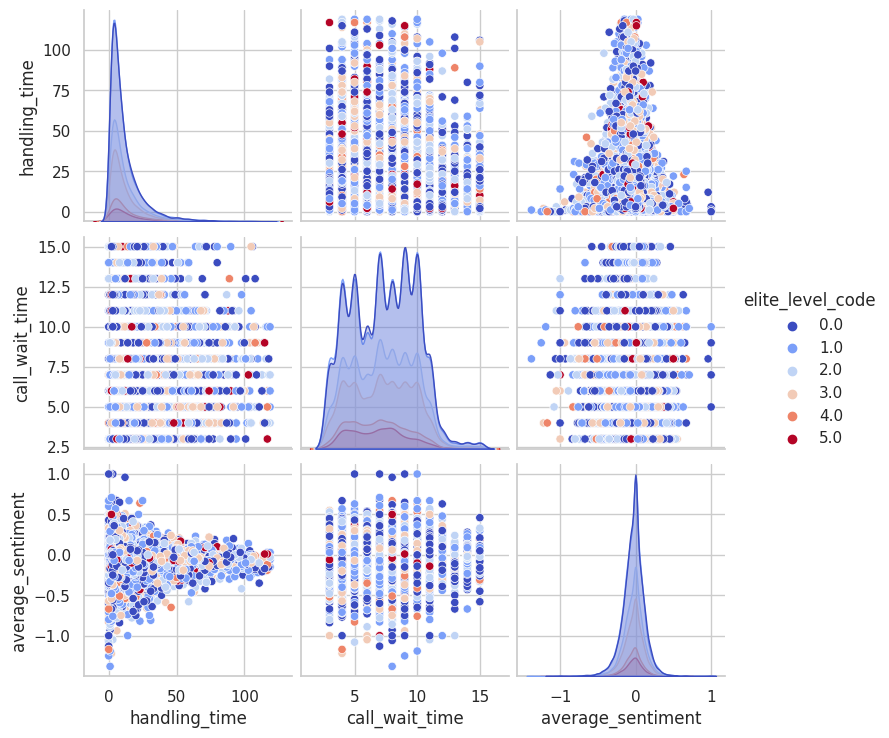

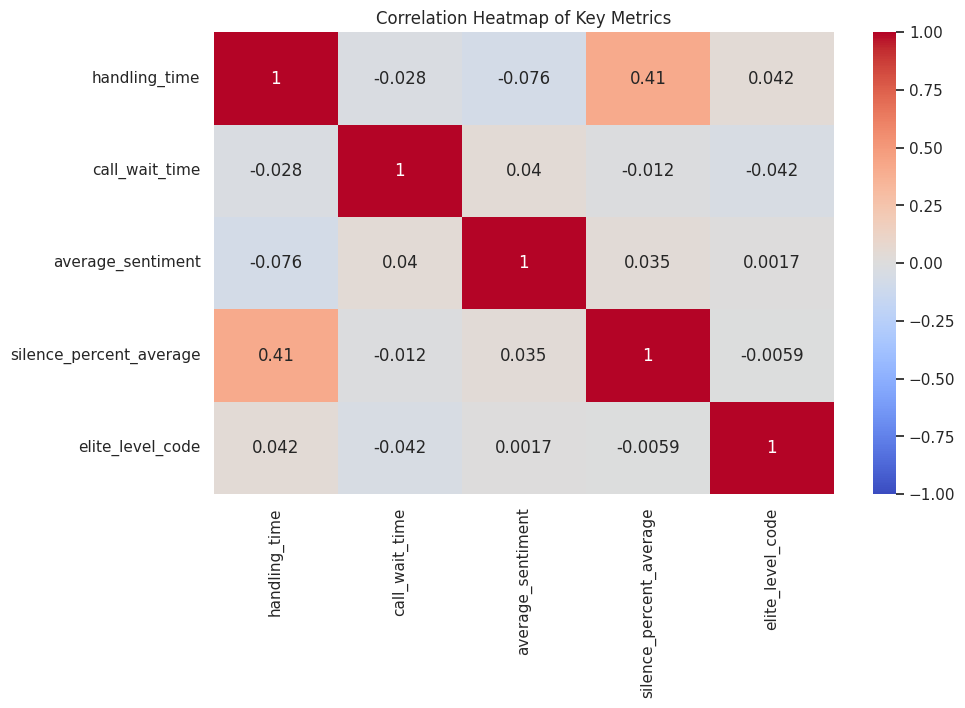

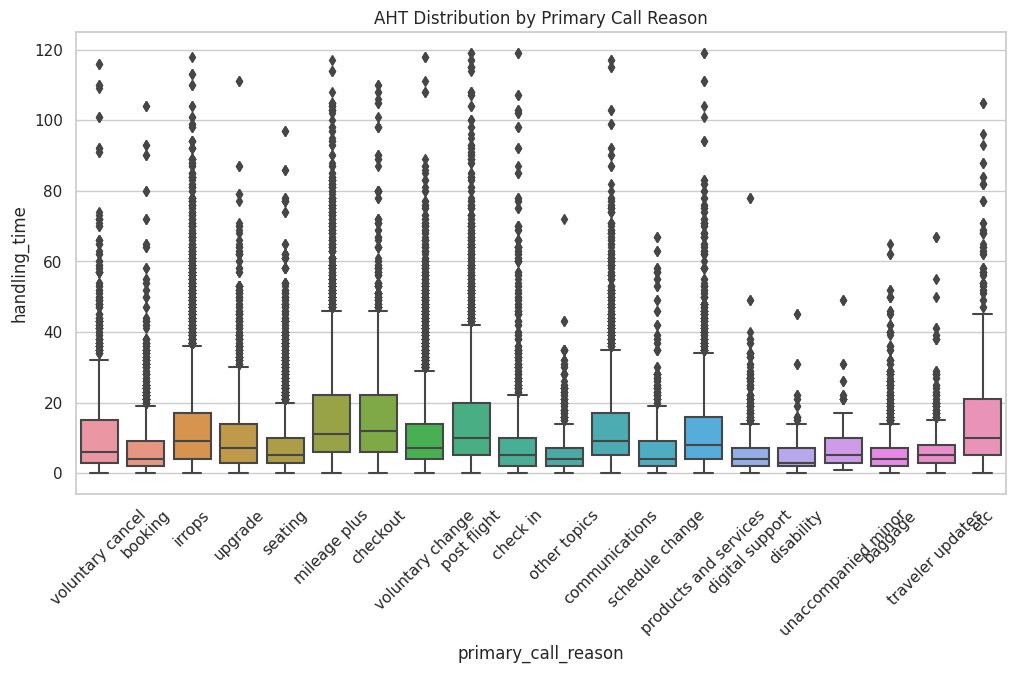

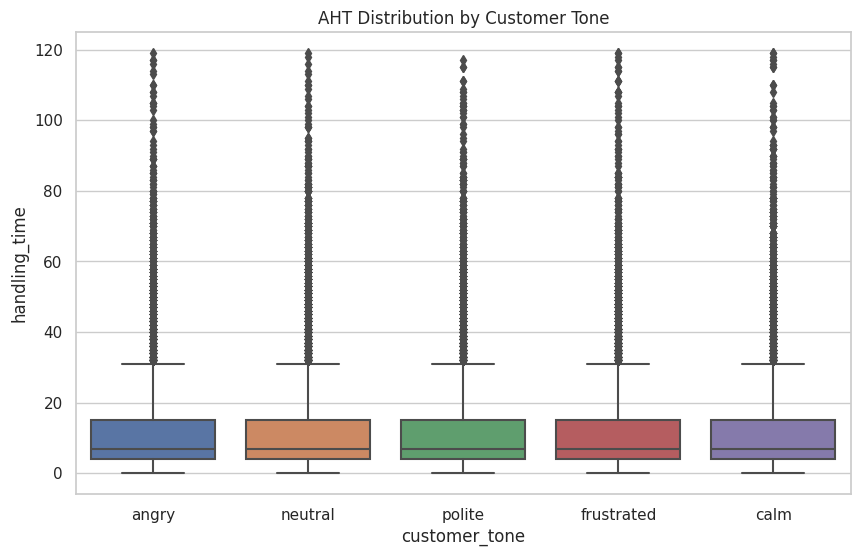

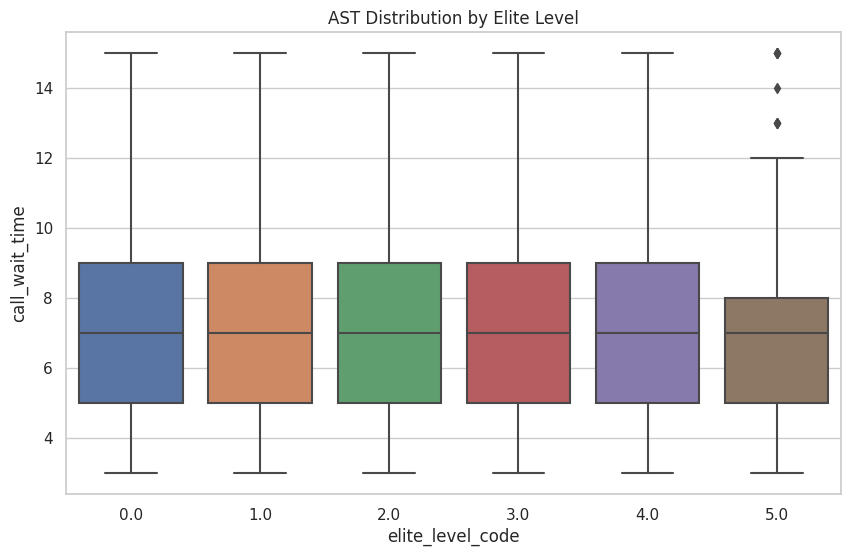

In [114]:

# Visualize relationships between AHT, AST, sentiment, and elite_level_code
sns.pairplot(merged_df[['handling_time', 'call_wait_time', 'average_sentiment', 'elite_level_code']], hue='elite_level_code', palette='coolwarm')
plt.show()

# Correlation heatmap to see which variables are strongly correlated
plt.figure(figsize=(10, 6))
corr = merged_df[['handling_time', 'call_wait_time', 'average_sentiment', 'silence_percent_average', 'elite_level_code']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Key Metrics')
plt.show()

# AHT by primary call reason to diagnose which call reasons lead to longer handle times
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='primary_call_reason', y='handling_time')
plt.xticks(rotation=45)
plt.title('AHT Distribution by Primary Call Reason')
plt.show()

# AHT by customer sentiment to analyze if negative tone leads to longer call durations
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='customer_tone', y='handling_time')
plt.title('AHT Distribution by Customer Tone')
plt.show()

# AST by elite level to see if elite customers experience lower AST
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='elite_level_code', y='call_wait_time')
plt.title('AST Distribution by Elite Level')
plt.show()


# Applying NLP to analyze call transcript speech

In [10]:
# Standardizing column names
def clean_column_names(df):
    df.columns = df.columns.str.strip().str.lower()
    return df

sentiment = clean_column_names(sentiment_df)
reason = clean_column_names(reason_df)
calls = clean_column_names(calls_df)
customer = clean_column_names(customers_df)

# Checking for duplicates and dropping them
dataframes = {
    'Sentiment Statistics DataFrame': sentiment,
    'Reason DataFrame': reason,
    'Calls DataFrame': calls,
    'Customer DataFrame': customer
}

for name, df in dataframes.items():
    print(f"{name} duplicates: {df.duplicated().sum()}")

# Dropping duplicates
sentiment.drop_duplicates(inplace=True)
reason.drop_duplicates(inplace=True)
calls.drop_duplicates(inplace=True)
customer.drop_duplicates(inplace=True)

# Missing values
for name, df in dataframes.items():
    print(f"\nMissing values in {name}:")
    print(df.isnull().sum())

# Dropping rows with missing 'call_transcript' as they are essential for analysis
merged_df.dropna(subset=['call_transcript'], inplace=True)
print("\nMerged DataFrame:")
print(merged_df.head())

# Function to separate agent and customer speech from the transcript
def separate_speech(transcript):
    agent_text = []
    customer_text = []
    
    # Splitting the transcript into lines
    lines = transcript.split('\n')
    
    for line in lines:
        line = line.strip()
        if line.startswith('Agent:'):
            agent_line = line.replace('Agent:', '').strip()
            agent_text.append(agent_line)
        elif line.startswith('Customer:'):
            customer_line = line.replace('Customer:', '').strip()
            customer_text.append(customer_line)
    
    return ' '.join(agent_text), ' '.join(customer_text)

# Apply the separation to each transcript
merged_df[['agent_speech', 'customer_speech']] = merged_df['call_transcript'].apply(
    lambda x: pd.Series(separate_speech(x))
)

# Separated speech
print("\nSeparated Agent and Customer Speech:")
print(merged_df[['agent_speech', 'customer_speech']].head())
# Function to clean and tokenize text
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply cleaning and tokenization to agent and customer speech
merged_df['agent_tokens'] = merged_df['agent_speech'].apply(clean_tokenize)
merged_df['customer_tokens'] = merged_df['customer_speech'].apply(clean_tokenize)

# Tokenized words
print("\nTokenized Agent and Customer Speech:")
print(merged_df[['agent_tokens', 'customer_tokens']].head())


Sentiment Statistics DataFrame duplicates: 0
Reason DataFrame duplicates: 0
Calls DataFrame duplicates: 0
Customer DataFrame duplicates: 0

Missing values in Sentiment Statistics DataFrame:
call_id                      0
agent_id                     0
agent_tone                 217
customer_tone                0
average_sentiment          109
silence_percent_average      0
dtype: int64

Missing values in Reason DataFrame:
call_id                0
primary_call_reason    0
dtype: int64

Missing values in Calls DataFrame:
call_id                    0
customer_id                0
agent_id                   0
call_start_datetime        0
agent_assigned_datetime    0
call_end_datetime          0
call_transcript            0
dtype: int64

Missing values in Customer DataFrame:
customer_id             0
customer_name           0
elite_level_code    25767
dtype: int64

Merged DataFrame:
      call_id  customer_id  agent_id_x call_start_datetime  \
0  4667960400   2033123310      963118     7/31/

In [11]:
# Agent tokens and customer tokens in single lists
all_agent_words = [word for tokens in merged_df['agent_tokens'] for word in tokens]
all_customer_words = [word for tokens in merged_df['customer_tokens'] for word in tokens]

# Frequency of words
agent_word_counts = Counter(all_agent_words)
customer_word_counts = Counter(all_customer_words)

# Most common words
print("\nMost Common Words by Agents:")
print(agent_word_counts.most_common(10))
print("\nMost Common Words by Customers:")
print(customer_word_counts.most_common(10))



Most Common Words by Agents:
[('flight', 363886), ('let', 257406), ('united', 151012), ('like', 148983), ('help', 147145), ('thank', 142111), ('typing', 141883), ('change', 137720), ('youre', 125062), ('would', 119341), ('take', 117167), ('okay', 115742), ('im', 107970), ('looks', 107910), ('get', 101302), ('look', 99285), ('today', 97482), ('calling', 95888), ('see', 91953), ('reservation', 90737), ('work', 89695), ('airlines', 84985), ('day', 81591), ('understand', 81486), ('travel', 81430), ('name', 76742), ('next', 75756), ('one', 75251), ('welcome', 72999), ('problem', 72206), ('could', 70321), ('please', 69831), ('pm', 67908), ('fee', 67884), ('may', 66614), ('check', 65566), ('pull', 65427), ('new', 62772), ('rest', 58093), ('time', 57221), ('confirmation', 57140), ('anything', 56767), ('know', 56693), ('chicago', 56335), ('ive', 53186), ('good', 52534), ('noises', 49933), ('options', 49175), ('customer', 47785), ('make', 46918), ('else', 46406), ('number', 45740), ('ahead', 45

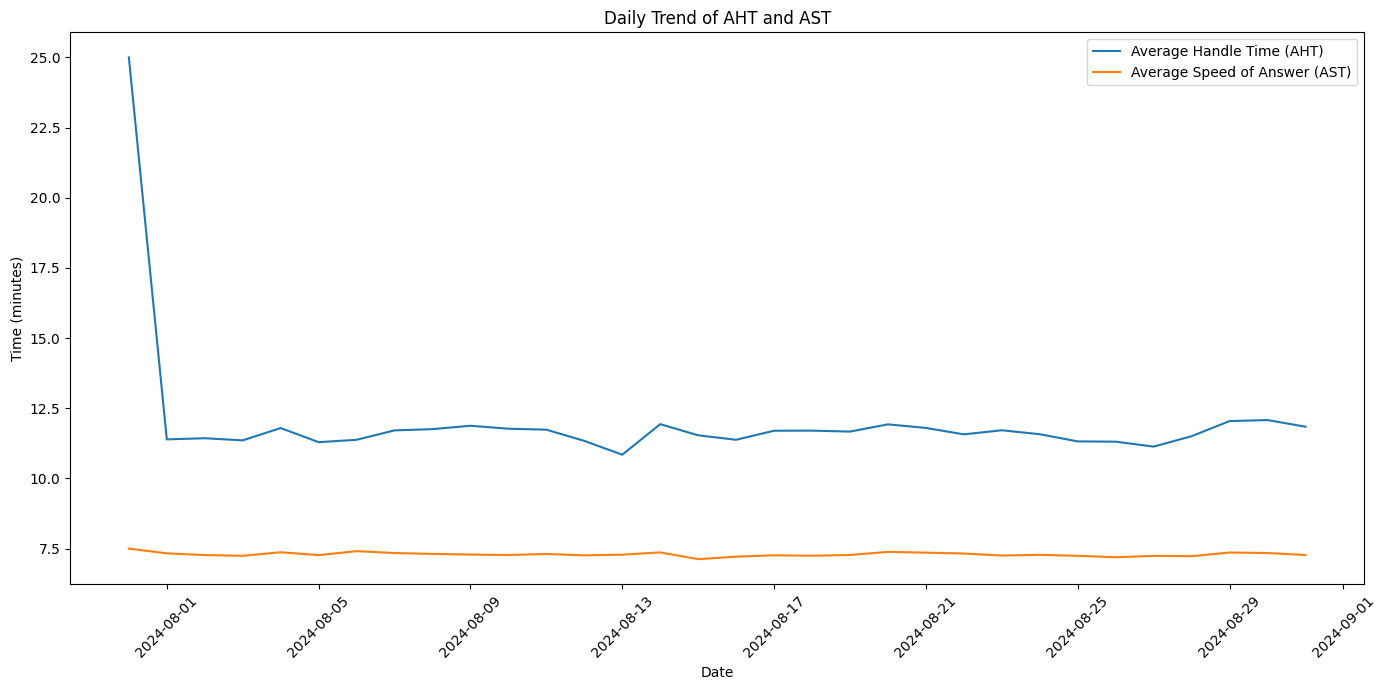

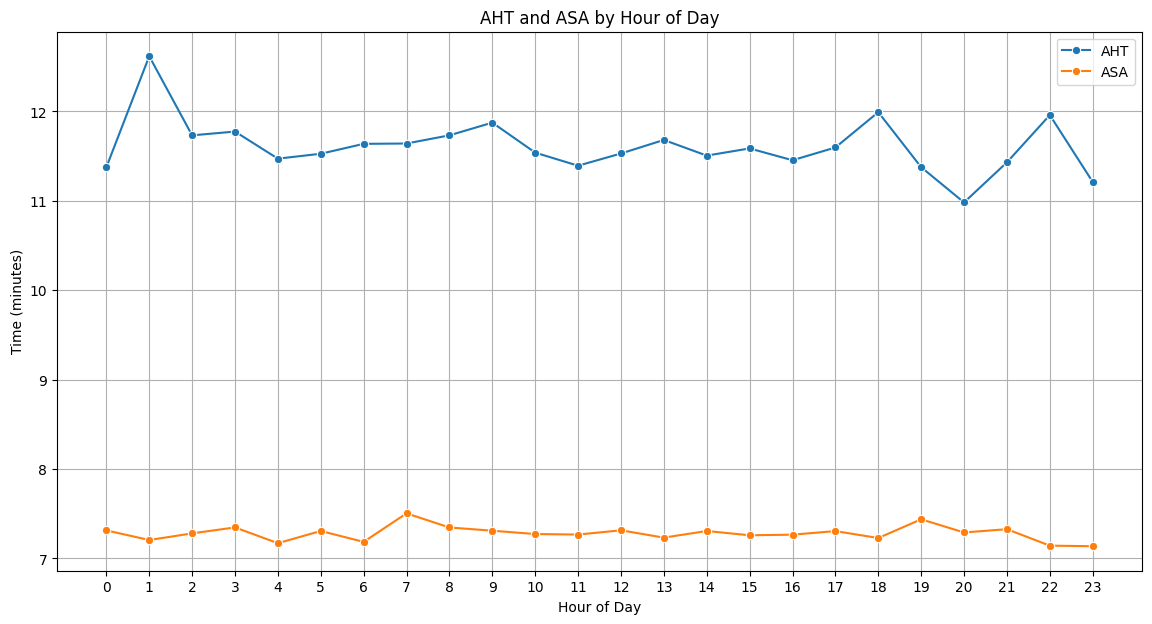

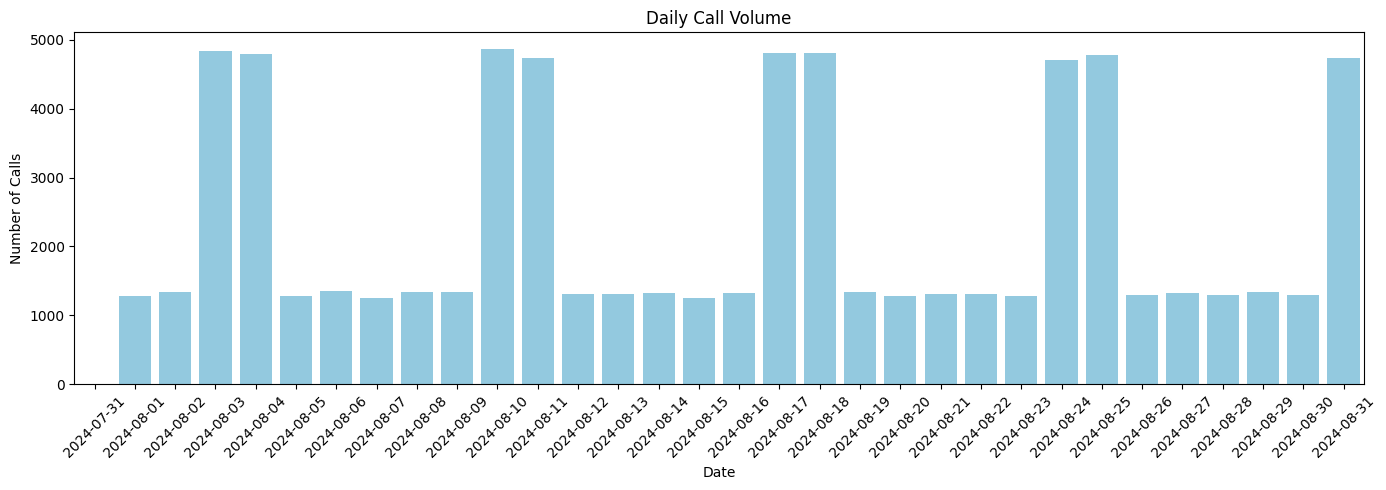

In [24]:
# Time based features
merged_df['call_date'] = merged_df['call_start_datetime'].dt.date
merged_df['call_hour'] = merged_df['call_start_datetime'].dt.hour
merged_df['call_weekday'] = merged_df['call_start_datetime'].dt.day_name()

# Aggregate data by date
daily_trends = merged_df.groupby('call_date').agg({
    'handling_time': 'mean',
    'call_wait_time': 'mean',
    'call_id': 'count'
}).rename(columns={'call_id': 'call_count'}).reset_index()

# Plots of AHT and AST over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_trends, x='call_date', y='handling_time', label='Average Handle Time (AHT)')
sns.lineplot(data=daily_trends, x='call_date', y='call_wait_time', label='Average Speed of Answer (AST)')
plt.title('Daily Trend of AHT and AST')
plt.xlabel('Date')
plt.ylabel('Time (minutes)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
hourly_performance = merged_df.groupby('call_hour').agg({
    'handling_time': 'mean',
    'call_wait_time': 'mean',
    'call_id': 'count'
}).rename(columns={'call_id': 'call_count'}).reset_index()

# AHT and ASA by Hour
plt.figure(figsize=(14, 7))
sns.lineplot(data=hourly_performance, x='call_hour', y='handling_time', marker='o', label='AHT')
sns.lineplot(data=hourly_performance, x='call_hour', y='call_wait_time', marker='o', label='ASA')
plt.title('AHT and ASA by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Time (minutes)')
plt.legend()
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()



# Call count over time
plt.figure(figsize=(14, 5))
sns.barplot(data=daily_trends, x='call_date', y='call_count', color='skyblue')
plt.title('Daily Call Volume')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Missing Values After Cleaning:
call_id                0
primary_call_reason    0
customer_id            0
customer_tone          0
dtype: int64

Top 10 Primary Call Reasons:
primary_call_reason
IRROPS                   13057
Voluntary Change         10291
Seating                   6223
Mileage Plus              5487
Post-Flight               3869
Communications            3779
Products and Services     2792
Upgrade                   2682
Baggage                   2616
Booking                   2589
Name: count, dtype: int64


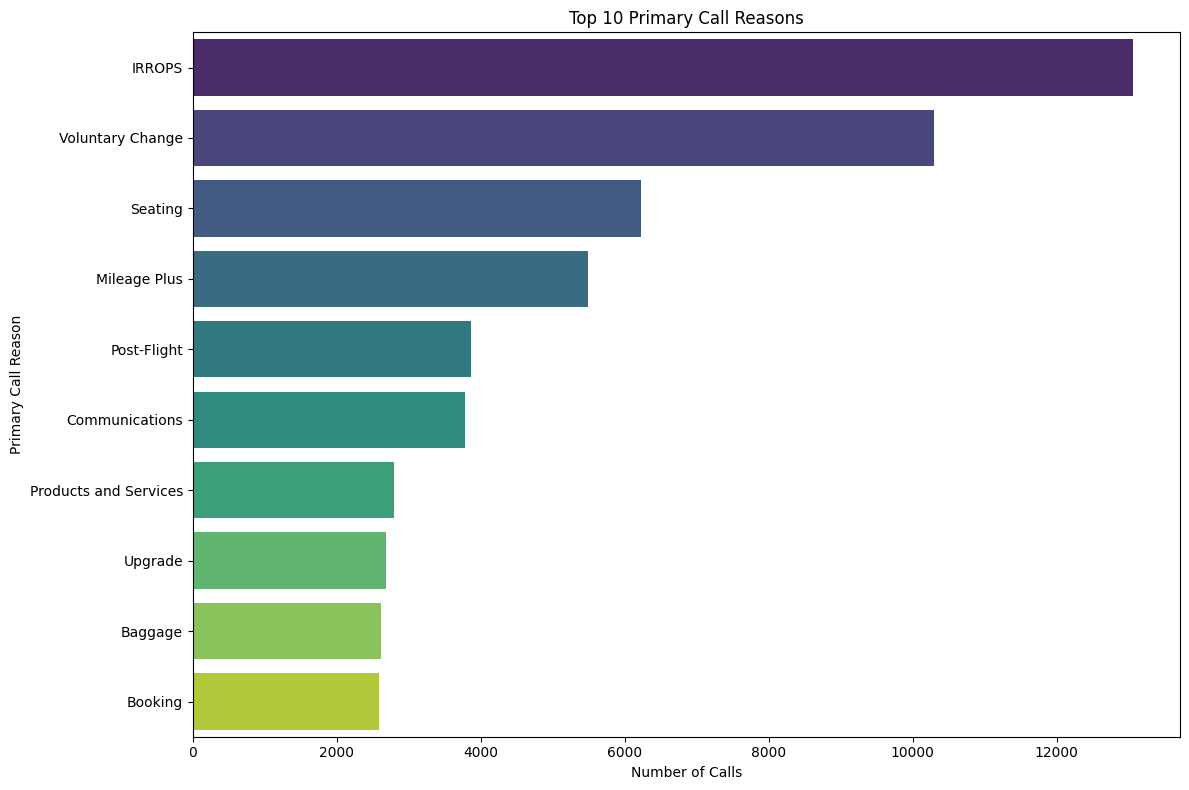

In [21]:
final_df_clean = merged_df.dropna(subset=['call_id', 'primary_call_reason', 'customer_id', 'customer_tone'])

# No missing values in the critical columns
print("\nMissing Values After Cleaning:")
print(final_df_clean[['call_id', 'primary_call_reason', 'customer_id', 'customer_tone']].isnull().sum())
import matplotlib.pyplot as plt
import seaborn as sns

# Calculating the top primary call reasons
top_call_reasons = final_df_clean['primary_call_reason'].value_counts().head(10)

# Displaying the top call reasons
print("\nTop 10 Primary Call Reasons:")
print(top_call_reasons)

# Bar plot of top primary call reasons
plt.figure(figsize=(12, 8))
sns.barplot(x=top_call_reasons.values, y=top_call_reasons.index, palette='viridis')
plt.title('Top 10 Primary Call Reasons')
plt.xlabel('Number of Calls')
plt.ylabel('Primary Call Reason')
plt.tight_layout()
plt.show()


Top 20 Unique Words in Long AHT Calls:
[('jean', 15), ('579', 13), ('484', 13), ('530', 12), ('hong', 12), ('kong', 12), ('vocalized', 11), ('622', 11), ('564', 11), ('546', 10), ('refine', 10), ('507', 10), ('905', 10), ('539', 10), ('933', 10), ('ua587', 9), ('515', 9), ('11c', 9), ('clare', 9), ('ua1581', 9)]


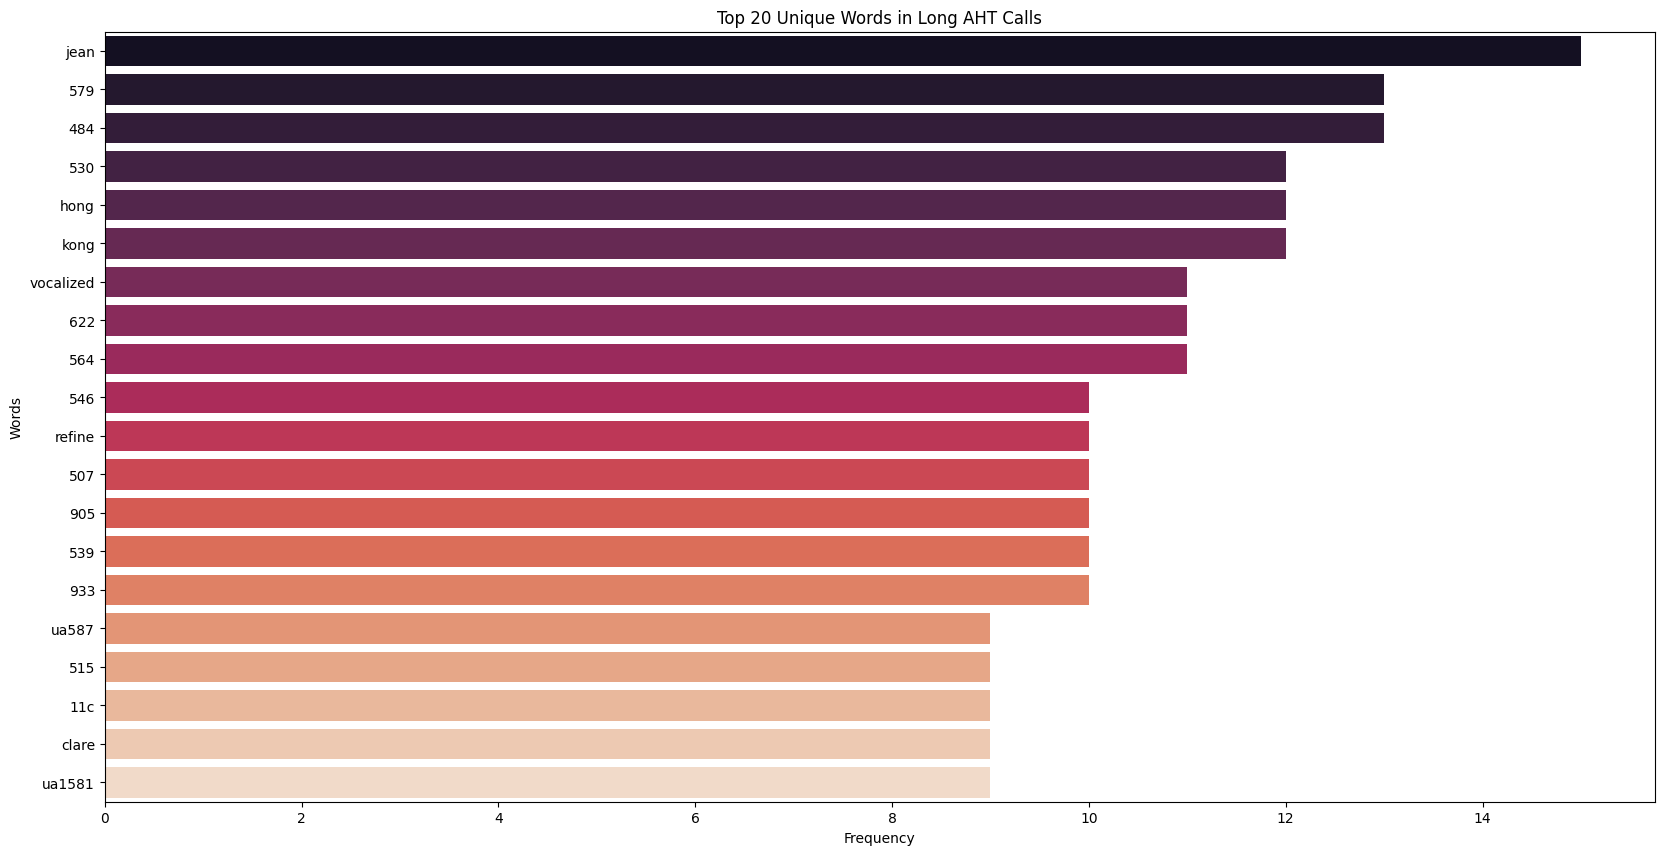

In [26]:
median_aht = merged_df['handling_time'].median()
long_aht_calls = merged_df[merged_df['handling_time'] > median_aht]['call_transcript']
short_aht_calls = merged_df[merged_df['handling_time'] <= median_aht]['call_transcript']

# Tokenization and cleaning
stop_words = set(stopwords.words('english'))

def tokenize_and_clean(transcripts):
    tokens = []
    for transcript in transcripts:
        words = word_tokenize(transcript.lower())
        words = [word for word in words if word.isalnum() and word not in stop_words]
        tokens.extend(words)
    return tokens

# Tokens for long and short AHT calls
tokens_long_aht = tokenize_and_clean(long_aht_calls)
tokens_short_aht = tokenize_and_clean(short_aht_calls)

# Word frequencies
freq_long_aht = Counter(tokens_long_aht)
freq_short_aht = Counter(tokens_short_aht)

# Commonly used words in long AHT not present in short AHT
unique_long_aht_words = set(freq_long_aht.keys()) - set(freq_short_aht.keys())

# Top 10 unique words in long AHT calls
unique_long_aht_freq = {word: freq_long_aht[word] for word in unique_long_aht_words}
top_unique_long_aht = Counter(unique_long_aht_freq).most_common(20)
print("Top 20 Unique Words in Long AHT Calls:")
print(top_unique_long_aht)

# Top unique words in long AHT calls
words, counts = zip(*top_unique_long_aht)
plt.figure(figsize=(20, 10))
sns.barplot(x=list(counts), y=list(words), palette='rocket')
plt.title('Top 20 Unique Words in Long AHT Calls')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()